In [307]:
import numpy as np
import random
import math

class Sensors():
    
    def __init__(self, operation_area, max_speed):
        self.operation_area = [
            [int(operation_area.split(',')[0]), int(operation_area.split(',')[1])],
            [int(operation_area.split(',')[2]), int(operation_area.split(',')[3])]
        ]
        
        self.max_speed = max_speed
         # Sensors
        self.all_sensors = list()
        self.messages = list()
        
        self.speedometer = list()
        self.location = list()
        self.temperature = list()
        self.pressure = list()
        self.wind_speed = list()
        self.wind_direction = list()
        
        self.last_speedometer = {'x': 0, 'y': 0}
        self.last_location = {'x': 0, 'y': 0}
        
        # BIAS SENSORs
        
        self.air_mean = np.random.normal(-55, 8, 1)[0]
        self.air_std = np.random.randint(1, 8)
        
        # K_means
        self.label = None
        
    def _move(self):
        x_movement = random.randint(0, self.max_speed) * (1 if random.random() < 0.5 else -1)
        y_movement = random.randint(0, self.max_speed) * (1 if random.random() < 0.5 else -1)

        if self.last_location['x'] + x_movement < self.operation_area[0][0]:
            x_movement = self.operation_area[0][0] - self.last_location['x']
        if self.last_location['x'] + x_movement > self.operation_area[1][0]:
            x_movement = self.operation_area[1][0] - self.last_location['x']
        if self.last_location['y'] + y_movement < self.operation_area[0][1]:
            y_movement = self.operation_area[0][1] - self.last_location['y']
        if self.last_location['y'] + y_movement > self.operation_area[1][1]:
            y_movement = self.operation_area[1][1] - self.last_location['y']

        self.last_location = {'x': self.last_location['x'] + x_movement,
                              'y': self.last_location['y'] + y_movement}
        self.last_speedometer = {'x': x_movement, 'y': y_movement}
        
        self.location.append(self.last_location)
        self.speedometer.append(self.last_speedometer)
        
        
    def _get_temperature(self):
        
        # Min : -77 Celcius, Max : -13 Celcius, Mean : -55 Celcius
        air_temperature_celcius = np.random.normal(self.air_mean, self.air_std, 1)[0]
        
        #pressure_pascals = np.random.normal(725, 48, 1)
        #rems_sensors = np.concatenate((air_temperature_celcius, pressure_pascals))
        self.temperature.append(air_temperature_celcius)
        return air_temperature_celcius
    
    def _get_pressure(self):
        
        pressure_pascals = np.random.normal(725, 48, 1)[0]
        #rems_sensors = np.concatenate((air_temperature_celcius, pressure_pascals))
        self.pressure.append(pressure_pascals)
        return pressure_pascals
    
    def _get_wind_speed(self):

        last_wind_speed = np.random.normal(7, 2, 1)[0]
        #rems_sensors = np.concatenate((air_temperature_celcius, pressure_pascals))
        self.wind_direction.append(last_wind_speed)
        return last_wind_speed
        
    def _get_wind_direction(self):
        x_wind_movement = random.randint(-1, 1)
        y_wind_movement = random.randint(-1, 1)
        
        last_wind_direction = math.atan2(y_wind_movement,x_wind_movement)/math.pi*180
        self.pressure.append(last_wind_direction)
        return last_wind_direction
    
    def update(self):
        
        self._move()
        last_temperature = self._get_temperature()
        last_pressure = self._get_pressure()
        last_wind_speed = self._get_wind_speed()
        last_wind_direction = self._get_wind_direction()
        
        self.all_sensors.append([self.last_location['x'], self.last_location['y'],
                         last_temperature, last_pressure, last_wind_speed, last_wind_direction])
        
        self.messages.append({"location(x)" : self.last_location['x'],
                         "location(y)" : self.last_location['y'],
                         "temperature:" : last_temperature, "pressure:" : last_pressure, 
                         "wind_speed:" : last_wind_speed, "wind_direction:" : last_wind_direction})
        
    def k_means(self):
        
        from kneed import KneeLocator
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score
        
        kmeans_kwargs = {
            "init": "random",
            "n_init": 10,
            "max_iter": 300,
            "random_state": 23,
        }

        # A list holds the SSE values for each k
        sse = []
        for k in range(1, 11):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(np.array(self.all_sensors))
            sse.append(kmeans.inertia_)
            
        kl = KneeLocator(
            range(1, 11), sse, curve="convex", direction="decreasing"
        )

        kmeans = KMeans(
            init = "random",
            n_clusters = kl.elbow,
            n_init = 10,
            max_iter = 300,
            random_state= 23
        )
        
        kmeans.fit(np.array(self.all_sensors))
        
        self.label = kmeans.fit_predict(np.array(self.all_sensors))
        return self.label

In [308]:
sensor1 = Sensors(operation_area = "0,0,1000,1000", max_speed = 10)
sensor2 = Sensors(operation_area = "0,2000,1000,3000", max_speed = 5)
sensor3 = Sensors(operation_area = "1000,1000,3000,1500", max_speed = 10)
sensor4 = Sensors(operation_area = "500,2500,1500,3000", max_speed = 5)
for i in range(100):
    sensor1.update()
    sensor2.update()
    sensor3.update()
    sensor4.update()

#print(np.array(sensor1.all_sensors)[:,2])

In [309]:
labels_1 = sensor1.k_means()

In [310]:
print(labels_1)

[1 1 1 2 0 2 2 1 2 2 1 1 0 1 2 0 1 1 2 2 0 2 0 2 0 2 1 0 2 0 1 1 1 1 2 1 1
 2 2 0 1 2 1 1 1 0 0 1 1 0 2 0 0 0 0 1 0 0 1 1 2 1 1 2 1 1 1 1 2 1 2 2 0 1
 2 1 1 0 0 0 2 1 1 2 2 2 0 1 1 2 0 0 0 0 1 2 1 0 1 0]


In [312]:
print(sensor1.messages[-1])

{'location(x)': 68, 'location(y)': 0, 'temperature:': -53.28398281828797, 'pressure:': 754.7610554247792, 'wind_speed:': 6.5341005580439715, 'wind_direction:': 90.0}


In [260]:
#print(np.array(sensor4.all_sensors)[:,2])

[-71.33222326 -71.24584349 -64.94894498 -67.06181229 -62.0729845
 -66.34312817 -65.71456018 -64.36347699 -67.16099345 -61.90272744
 -66.26180514 -60.53621076 -62.40063135 -68.82783371 -58.96207596
 -67.38582617 -63.40897862 -67.92876636 -56.77981761 -71.92526746
 -57.47275524 -66.45224427 -67.47862702 -63.27894331 -64.3967673
 -60.31353526 -72.43034004 -73.20999134 -68.45373201 -68.02981676
 -65.70725228 -72.07960342 -61.69446152 -61.02981979 -58.36298396
 -71.2670424  -70.09232435 -71.79524635 -69.10738415 -57.36353912
 -65.50647824 -76.95398414 -77.43936032 -65.65828244 -57.50463735
 -68.2266512  -74.0699718  -69.64377997 -65.74778543 -67.63107569
 -73.68545262 -71.28267871 -64.01710717 -64.74450977 -67.89405971
 -69.10059729 -70.41792559 -71.95544768 -60.12675298 -62.89807592
 -70.3960742  -58.48717692 -68.37723155 -64.46353045 -61.18606808
 -78.49011842 -55.25757561 -75.15403828 -72.34239124 -69.60753115
 -67.71447724 -66.85075978 -72.64129302 -70.86361884 -69.79533315
 -70.0673167

In [261]:
# def get_labels_for_temperature(sensor):
#     labels = list()
#     for x in np.array(sensor1.all_sensors)[:,2]:
#         if (x < -65):
#             labels.append(-1)
#         elif(x > -45):
#             labels.append(1)
#         else:
#             labels.append(0)
    
#     return np.array(labels)

In [262]:
# labels_temp_1 = get_labels_for_temperature(sensor1)
# labels_temp_2 = get_labels_for_temperature(sensor2)
# labels_temp_3 = get_labels_for_temperature(sensor3)
# labels_temp_4 = get_labels_for_temperature(sensor4)

In [263]:
# # Sensor Data Visualization
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# plt.rc('font', size=18)
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

# sensor_lib = [sensor1, sensor2, sensor3, sensor4]
# ax_lib = [ax1,ax2,ax3,ax4]
# labels_lib = [labels_temp_1, labels_temp_2, labels_temp_3, labels_temp_4]
# for i,ax in enumerate (ax_lib):
    
    
#     indeces_1 = np.where(labels_lib[i] == 1)[0]
#     indeces_minus_1 = np.where(labels_lib[i] == -1)[0]
#     indeces_zero = np.where(labels_lib[i] == 0)[0]
    
#     ax.scatter(np.array(sensor_lib[i].all_sensors)[indeces_1, 0],
#                np.array(sensor_lib[i].all_sensors)[indeces_1, 1], 
#                c = "blue", marker="o" , label ="COLD")
    
#     ax.scatter(np.array(sensor_lib[i].all_sensors)[indeces_zero, 0],
#                np.array(sensor_lib[i].all_sensors)[indeces_zero, 1], 
#                c = "gray", marker="o" , label ="NORMAL")
    
#     ax.scatter(np.array(sensor_lib[i].all_sensors)[indeces_minus_1, 0],
#                np.array(sensor_lib[i].all_sensors)[indeces_minus_1, 1],
#                c = 'red' , marker="o", label = "HOT")
    
#     #ax.scatter(sensor_lib[i].all_sensors[0], sensor_lib[i].all_sensors[1], labels_temp_1)
#     ax.set_title('Sensor Data for Rover {a}' .format(a= i+1), pad=20)
#     ax.set(xlabel = "X Coordination" , ylabel = 'Y Coordination')
#     ax.xaxis.labelpad = 20
#     ax.yaxis.labelpad = 20
#     if (i % 2 == 1):
#         ax.legend( bbox_to_anchor=(1, 0.5), title = "Labels")

# plt.subplots_adjust(wspace=0.5, hspace=0.7, left=0, right=1, bottom=0, top=1.2)
# plt.show()

In [264]:
# from kneed import KneeLocator
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

In [265]:
# kmeans_kwargs = {
#     "init": "random",
#     "n_init": 10,
#     "max_iter": 300,
#     "random_state": 23,
# }

# # A list holds the SSE values for each k
# sse = []
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#     kmeans.fit(np.array(sensor2.all_sensors)[:,0:3])
#     sse.append(kmeans.inertia_)

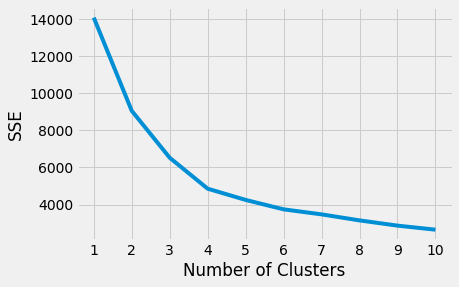

In [266]:
# plt.style.use("fivethirtyeight")
# plt.plot(range(1, 11), sse)
# plt.xticks(range(1, 11))
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")
# plt.show()

In [267]:
# kl = KneeLocator(
#     range(1, 11), sse, curve="convex", direction="decreasing"
# )

# kl.elbow

4

In [268]:
# kmeans = KMeans(
#     init = "random",
#     n_clusters = kl.elbow,
#     n_init = 10,
#     max_iter = 300,
#     random_state= 23
# )

In [269]:
# kmeans.fit(np.array(sensor2.all_sensors)[:,0:-1])

KMeans(init='random', n_clusters=4, random_state=23)

In [270]:
# kmeans_silhouette = silhouette_score(sensor2.all_sensors, kmeans.labels_)

In [271]:
# print(kmeans_silhouette)

-0.01538538394341475


[1 0 2 0 2 0 1 0 0 0 0 0 0 1 2 0 2 2 2 1 0 2 2 0 2 1 2 0 1 2 1 2 1 0 0 1 2
 2 0 3 0 3 2 0 0 2 2 2 0 1 2 2 0 0 0 3 2 0 0 0 0 0 0 2 0 3 0 2 2 2 1 0 0 1
 0 3 0 2 1 0 1 0 2 0 0 0 1 2 2 0 0 0 2 1 2 2 2 1 2 3]


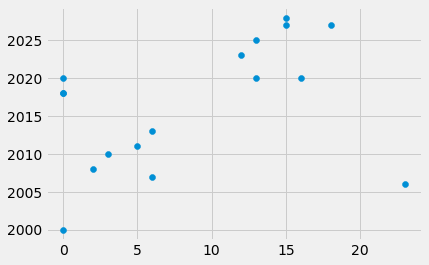

In [274]:
# label = kmeans.fit_predict(sensor2.all_sensors)
# print(label)
# #filter rows of original data
# filtered_label0 = np.array(sensor2.all_sensors)[label == 1]
 
# #plotting the results
# plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
# plt.show()

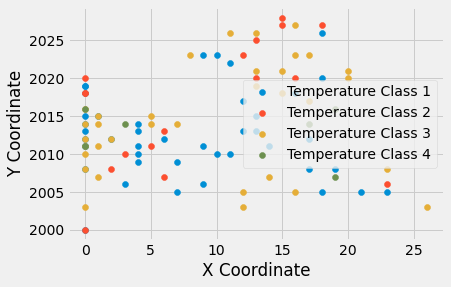

In [273]:
# #Getting unique labels
 
# u_labels = np.unique(label)
 
# #plotting the results:
 
# for i in u_labels:
#     plt.scatter(np.array(sensor2.all_sensors)[label == i , 0] , np.array(sensor2.all_sensors)[label == i , 1] , label = i)
# plt.legend(['Temperature Class 1', 'Temperature Class 2', 'Temperature Class 3', 'Temperature Class 4'])

# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.show()
